# Homography evaluation

#### Author: Maxence Gélard
maxence.gelard@student-cs.fr

This second notebook corresponds to the source code that perform the evaluation of the homography estimation that is used in the panorama reconstruction pipeline.

In particular, we look at the results (both in terms of performance and computing time) for different detectors and different distances (for descriptors matching):

- SIFT detector: brute force L1 and Flann matchers.

- ORB detector: brute force L1 and Hamming matchers.

In [1]:
import os
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import normalized_mutual_info_score
import itertools
from collections import defaultdict

In [2]:
class HomographyEvaluator:
    def __init__(self):
        self.reference_images_path = "homography_dataset/reference"
        self.transformed_images_path = "homography_dataset/transformed"
        self.homography_path = "homography_dataset/homography"
        
        self.nn_match_ratio = 0.8
        
    def evaluate_featurizer(self, image_name, featurizer, matcher_distance = cv2.DescriptorMatcher_BRUTEFORCE_L1):
        image_1 = cv2.imread(os.path.join(self.reference_images_path, image_name))
        image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
        image_2 = cv2.imread(os.path.join(self.transformed_images_path, image_name))
        image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
        
        # Load the true homography
        homography_name = image_name.split(".")[0] + ".txt"
        H_ref = np.loadtxt(os.path.join(self.homography_path, homography_name))
        
        # Compute keypoints and descriptors on both images
        keypoints_1, descriptors_1 = featurizer.detectAndCompute(image_1, None)
        keypoints_2, descriptors_2 = featurizer.detectAndCompute(image_2, None)
        
        # Define the 2-Nearest-Neighbors matcher with the defined distance (L1, Hamming, ...)
        matcher = cv2.DescriptorMatcher_create(matcher_distance)
        nn_matches = matcher.knnMatch(descriptors_1, descriptors_2, 2)
        
        # Look for "good matches", i.e match that satisfy 
        # the relation distance(first_neighbor) < ratio * distance(second_neighbor)
        matched_1 = []
        matched_2 = []
        
        for first_match, second_match in nn_matches:
            if first_match.distance < self.nn_match_ratio * second_match.distance:
                matched_1.append(keypoints_1[first_match.queryIdx])
                matched_2.append(keypoints_2[first_match.trainIdx])
                
        # Compute the number of inliners
        inliers_1 = []
        inliers_2 = []
        good_matches = []
        inlier_threshold = 2
        for m, n in zip(matched_1, matched_2):
            descriptor = np.array([m.pt[0], m.pt[1], 1])
            transformed_descriptor = np.dot(H_ref, descriptor)
            flatten_descriptor = np.array([
                transformed_descriptor[0],
                transformed_descriptor[1]
            ]) / transformed_descriptor[2]
            matching_distance = np.linalg.norm(flatten_descriptor - n.pt)
            if matching_distance < inlier_threshold * 100:
                good_matches.append(cv2.DMatch(len(inliers_1), len(inliers_2), 0))
                inliers_1.append(m)
                inliers_2.append(n)
                
        matched_images = np.empty(
            (max(image_1.shape[0], image_2.shape[0]), image_1.shape[1] + image_2.shape[1], 3),
             dtype=np.uint8
        )
        cv2.drawMatches(image_1, inliers_1, image_2, inliers_2, good_matches, matched_images)
        score = len(inliers_1) / len(matched_1) * 100
        return matched_images, score
    
    def evaluate_dataset(self, featurizer_dict, matching_distance_dict):
        images_names_list = os.listdir(self.reference_images_path)
        results = {}
        for featurizer_name, featurizer in featurizer_dict.items():
            print(f"--- Processing featurizer {featurizer_name} ---")
            result_featurizer = {}
            for matching_distance_name, matching_distance in matching_distance_dict.items():
                start = time.perf_counter()
                print(f"\t Processing distance {matching_distance_name}")
                result_distance = {}
                for image_name in images_names_list:
                    print(f"\t \tProcessing image {image_name}")
                    try:
                        matched_image, score = self.evaluate_featurizer(image_name, featurizer, matching_distance)
                        result_distance[image_name] = score
                    except:
                        # Handle case where detector and metric aren't compatible
                        result_distance[image_name] = -1
                duration = time.perf_counter() - start
                result_featurizer[matching_distance_name] = {
                    "scores": result_distance,
                    "time": duration / len(images_names_list)
                }
            results[featurizer_name] = result_featurizer
        return results

In [3]:
evaluator = HomographyEvaluator()

featurizer = cv2.ORB_create(10000)
matching_distance = cv2.DescriptorMatcher_BRUTEFORCE_L1

image_name = "adam.png"
result, score = evaluator.evaluate_featurizer(image_name, featurizer, matching_distance)

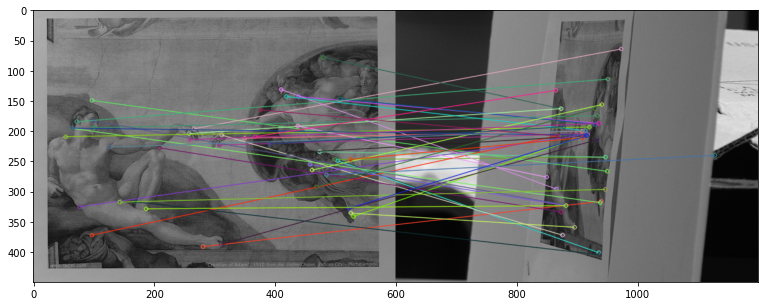

In [4]:
plt.figure(figsize=(15, 5))
plt.imshow(result)

In [5]:
featurizer_dict = {
    "sift": cv2.SIFT_create(),
    "orb": cv2.ORB_create(10000)
}
matching_distance_dict = {
    "l1": cv2.DescriptorMatcher_BRUTEFORCE_L1,
    "flann": cv2.DescriptorMatcher_FLANNBASED,
    "hamming": cv2.DescriptorMatcher_BRUTEFORCE_HAMMING
}
full_results = evaluator.evaluate_dataset(featurizer_dict, matching_distance_dict)

--- Processing featurizer sift ---
	 Processing distance l1
	 	Processing image vin.png
	 	Processing image grand.png
	 	Processing image there.png
	 	Processing image index.png
	 	Processing image cafe.png
	 	Processing image dum.png
	 	Processing image mag.png
	 	Processing image shop.png
	 	Processing image girl.png
	 	Processing image face.png
	 	Processing image cat.png
	 	Processing image adam.png
	 	Processing image fox.png
	 	Processing image pkk.png
	 	Processing image graf.png
	 Processing distance flann
	 	Processing image vin.png
	 	Processing image grand.png
	 	Processing image there.png
	 	Processing image index.png
	 	Processing image cafe.png
	 	Processing image dum.png
	 	Processing image mag.png
	 	Processing image shop.png
	 	Processing image girl.png
	 	Processing image face.png
	 	Processing image cat.png
	 	Processing image adam.png
	 	Processing image fox.png
	 	Processing image pkk.png
	 	Processing image graf.png
	 Processing distance hamming
	 	Processing imag

In [6]:
sift_result = np.mean(list(full_results["sift"]["l1"]["scores"].values()))
orb_result = np.mean(list(full_results["orb"]["l1"]["scores"].values()))

In [7]:
print(f"Sift mean score: {sift_result}")
print(f"Orb mean score: {orb_result}")

Sift mean score: 26.858727714296233
Orb mean score: 27.306880473189686


In [8]:
sift_result_flann = np.mean(list(full_results["sift"]["flann"]["scores"].values()))
orb_result_flann = np.mean(list(full_results["orb"]["flann"]["scores"].values()))

In [9]:
print(f"Sift mean score: {sift_result}")
print(f"Orb mean score: {orb_result}")

Sift mean score: 26.858727714296233
Orb mean score: 27.306880473189686


In [10]:
sift_result_time = {"l1": full_results["sift"]["l1"]["time"], "flann": full_results["sift"]["flann"]["time"]}
orb_result_time = {"l1": full_results["orb"]["l1"]["time"], "hamming": full_results["orb"]["hamming"]["time"]}

In [11]:
mean_l1_sift_time = sift_result_time["l1"]
mean_l1_orb_time = orb_result_time["l1"]
mean_flann_time = sift_result_time["flann"]
mean_hamming_time = orb_result_time["hamming"]


print(f"Mean L1 time - SIFT: {mean_l1_sift_time}s per image")
print(f"Mean L1 time - ORB: {mean_l1_orb_time}s per image")
print(f"Mean Flann time: {mean_flann_time}s per image")
print(f"Mean Hamming time: {mean_hamming_time}s per image")

Mean L1 time - SIFT: 0.6550139690666666s per image
Mean L1 time - ORB: 0.2737975722666666s per image
Mean Flann time: 0.3850283992666668s per image
Mean Hamming time: 0.4658395458000001s per image


In [12]:
sift_result_l1 = np.mean(list(full_results["sift"]["l1"]["scores"].values()))
sift_result_flann = np.mean(list(full_results["sift"]["flann"]["scores"].values()))

orb_result_l1 = np.mean(list(full_results["orb"]["l1"]["scores"].values()))
orb_result_hamming = np.mean(list(full_results["orb"]["hamming"]["scores"].values()))

In [13]:
print(f"Sift mean score l1: {sift_result_l1}")
print(f"Orb mean score l1: {orb_result_l1}")

print(f"Sift mean score flann: {sift_result_flann}")
print(f"Orb mean score hamming: {orb_result_hamming}")

Sift mean score l1: 26.858727714296233
Orb mean score l1: 27.306880473189686
Sift mean score flann: 24.750022377102713
Orb mean score hamming: 27.247898509007552
